<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/half_chess_board.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo

In [11]:
!pip install ortools
from ortools.sat.python import cp_model # CP-SAT solver
import numpy as np
from random import randint
import random
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt # Data visualization
import time
#plt.rcParams["figure.figsize"] = (15,10)

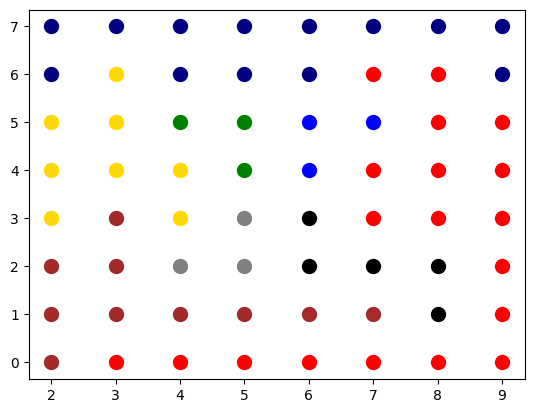

64

In [12]:
dic = {
    (1, 1): 4, (1, 2): 4, (1, 3): 4, (1, 4): 4, (1, 5): 4, (1, 6): 4, (1, 7): 4, (1, 8): 4,
    (2, 1): 4, (2, 2): 5, (2, 3): 4, (2, 4): 4, (2, 5): 4, (2, 6): 1, (2, 7): 1, (2, 8): 4,
    (3, 1): 5, (3, 2): 5, (3, 3): 6, (3, 4): 6, (3, 5): 3, (3, 6): 3, (3, 7): 1, (3, 8): 1,
    (4, 1): 5, (4, 2): 5, (4, 3): 5, (4, 4): 6, (4, 5): 3, (4, 6): 1, (4, 7): 1, (4, 8): 1,
    (5, 1): 5, (5, 2): 8, (5, 3): 5, (5, 4): 7, (5, 5): 2, (5, 6): 1, (5, 7): 1, (5, 8): 1,
    (6, 1): 8, (6, 2): 8, (6, 3): 7, (6, 4): 7, (6, 5): 2, (6, 6): 2, (6, 7): 2, (6, 8): 1,
    (7, 1): 8, (7, 2): 8, (7, 3): 8, (7, 4): 8, (7, 5): 8, (7, 6): 8, (7, 7): 2, (7, 8): 1,
    (8, 1): 8, (8, 2): 1, (8, 3): 1, (8, 4): 1, (8, 5): 1, (8, 6): 1, (8, 7): 1, (8, 8): 1
}
KOLORs = ['r','k','b','navy','gold','g','grey','brown','grey','orange']
info = {}
c= 0
for (i,j),v in dic.items():
  x,y = i,j
  plt.scatter(1+y,8-x,s=100, c= KOLORs[v-1])
  c+=1
  info[c] = (1+y,8-x,v)
plt.show()
c

In [13]:
N = len(dic)
info_color = {}
for c,(x,y,v) in info.items():
  info_color[v] = info_color.get(v,[])+[c]
X= {x for (x,y,c) in info.values()}
Y= {y for (x,y,c) in info.values()}

sorted_y = sorted(Y)
X,Y,sorted_y

({2, 3, 4, 5, 6, 7, 8, 9}, {0, 1, 2, 3, 4, 5, 6, 7}, [0, 1, 2, 3, 4, 5, 6, 7])

In [32]:
def dist(i,j):
  return int((info[i][0]-info[j][0])**2+(info[i][1]-info[j][1])**2)
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0
        self.__save_solution = {}



    def on_solution_callback(self):
        self.__solution_count += 1
        #print(self.__solution_count , [self.Value(self.__variables[i]) for i in self.__variables])
        self.__save_solution[self.__solution_count] = {i:self.Value(self.__variables[i]) for i in self.__variables}
        if self.__solution_count == 7:
          self.StopSearch()

    def solution_count(self):
        return self.__solution_count
    def solution_save(self):
        return self.__save_solution


model = cp_model.CpModel()
solver = cp_model.CpSolver()
nodes = range(1,N+1)
U = {c:model.NewBoolVar(f"blackcell_{c}") for c in nodes}
Z = {(i,j):model.NewBoolVar(f"Z_{i}_{j}") for i in nodes for j in nodes if dist(i,j) == 1}
flow = {(i,j):model.NewIntVar(0,int(N/2), f"flow_{i}_{j}") for i in nodes for j in nodes if dist(i,j) == 1}


W = {(i,j):model.NewBoolVar(f"W_{i}_{j}") for i in nodes for j in nodes if dist(i,j) == 1}
flowW = {(i,j):model.NewIntVar(0,int(N/2), f"flowW_{i}_{j}") for i in nodes for j in nodes if dist(i,j) == 1}

blacks = {c:model.NewBoolVar(f"blacks_{c}") for c in nodes}
whites = {c:model.NewBoolVar(f"whites_{c}") for c in nodes}

colors = info_color.keys()

for (i,j),v in Z.items():
  model.Add(v<=U[i])
  model.Add(v<=U[j])

for (i,j),vw in W.items():
  model.Add(vw<=1-U[i])
  model.Add(vw<=1-U[j])
  model.AddAtMostOne([vw, Z[i,j]])

for i in nodes:
  model.Add(int(N/2)*blacks[i] - U[i] == sum(flow[i,j]-flow[j,i] for j in nodes if (i,j) in flow) )

for i in nodes:
  model.Add(int(N/2)*whites[i] - (1-U[i]) == sum(flowW[i,j]-flowW[j,i] for j in nodes if (i,j) in flowW) )

for i in nodes:
  model.Add(blacks[i] + whites[i] <= 1)
  model.Add(blacks[i]  <= U[i])
  model.Add(whites[i]  <= 1-U[i])


expressions = [blacks[n] for n in nodes ]
model.AddExactlyOne(expressions)

expressions = [whites[n] for n in nodes ]
model.AddExactlyOne(expressions)

for (i,j),v in Z.items():
  model.Add(flow[i,j] == 0).OnlyEnforceIf(v.Not())

for (i,j),vw in W.items():
  model.Add(flowW[i,j] == 0).OnlyEnforceIf(vw.Not())


expressions_up = [U[n] for n in nodes if info[n][1] >= 0.5*(max(Y)+min(Y))]
expressions_down = [U[n] for n in nodes if info[n][1] < 0.5*(max(Y)+min(Y))]
model.Add(sum(expressions_up) >= sum(expressions_down) )


expressions = [U[n] for n in nodes ]
model.Add(sum(expressions) == int(N/2) )

solver.parameters.enumerate_all_solutions = False
solution_printer = VarArraySolutionPrinter(U)


st = time.time()
status = solver.Solve(model, solution_printer)

et = time.time()
print(f"time = {et-st}")
print(f"status = {solver.StatusName(status)}")
print(f"Number of solutions found: {solution_printer.solution_count()}")

time = 0.07570934295654297
status = OPTIMAL
Number of solutions found: 1


whites 1
Black 2


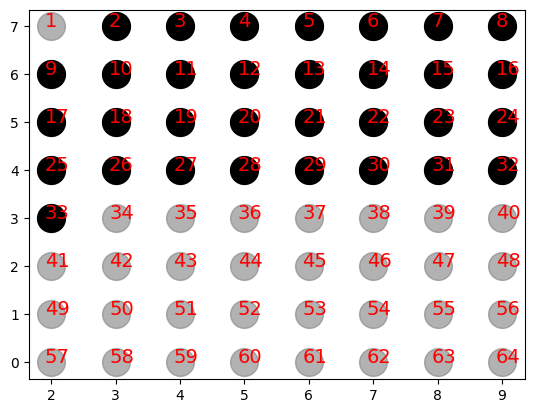

In [33]:
for c,(x,y,v) in info.items():
  plt.scatter(x,y,s=400, c= 'grey', alpha= 0.6)

for i in nodes:
  plt.text(info[i][0]-0.1,info[i][1],s=str(i), c= 'r', fontsize=14)
  if solver.Value(blacks[i]):
    print("Black",i)
  if solver.Value(whites[i]):
    print("whites",i)


for i ,v in U.items():
  if solver.Value(v):
    plt.scatter(info[i][0],info[i][1],s=400, c= 'k')

plt.show()

1 {1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0}


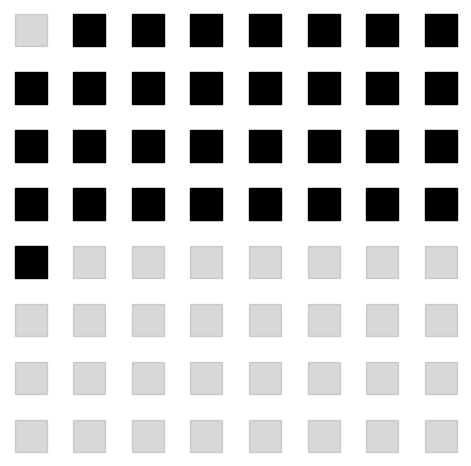

In [34]:
for i , dic in solution_printer.solution_save().items():
  plt.figure(figsize=(5,5))
  print(i, dic)
  for c,v in dic.items():
    if v:
      plt.scatter(info[c][0],info[c][1],s=500, marker = 's', c= 'k')
    else:
      plt.scatter(info[c][0],info[c][1],s=500, marker = 's', c= 'grey', alpha = 0.3)
  plt.tight_layout()
  plt.axis('off')
  plt.show()



1 {1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0}
Black 2


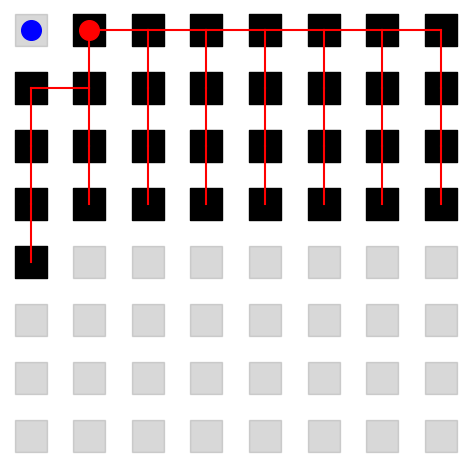

In [35]:
for i , dic in solution_printer.solution_save().items():
  plt.figure(figsize=(5,5))
  print(i, dic)
  for c,v in dic.items():
    if v:
      plt.scatter(info[c][0],info[c][1],s=500, marker = 's', c= 'k')
    else:
      plt.scatter(info[c][0],info[c][1],s=500, marker = 's', c= 'grey', alpha = 0.3)

  for i in nodes:
    if solver.Value(blacks[i]):
      plt.scatter(info[i][0],info[i][1],s=200, marker = 'o', c= 'r')
      print("Black",i)
    if solver.Value(whites[i]):
      plt.scatter(info[i][0],info[i][1],s=200, marker = 'o', c= 'b')

  for (i,j), vz in Z.items():
    if solver.Value(vz):
      plt.plot([info[i][0],info[j][0]],[info[i][1],info[j][1]],c= 'r')
  for (i,j), vw in W.items():
    if solver.Value(vw):
      plt.plot([info[i][0],info[j][0]],[info[i][1],info[j][1]],c= 'b')
  plt.tight_layout()
  plt.axis('off')
  plt.show()


1


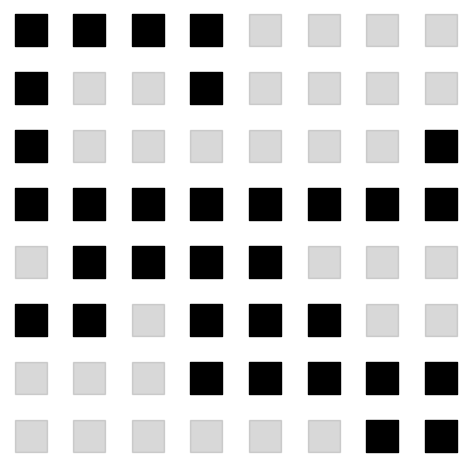

2


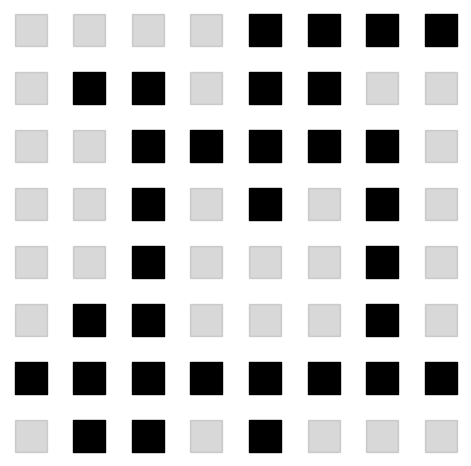

3


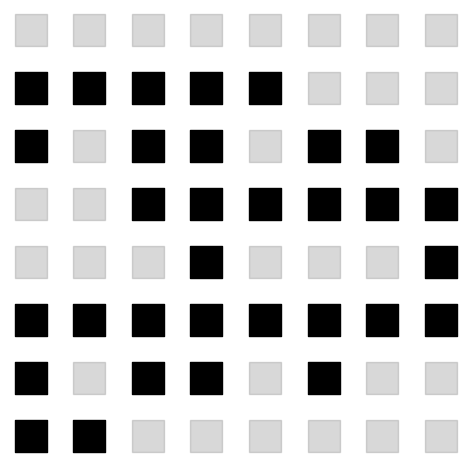

4


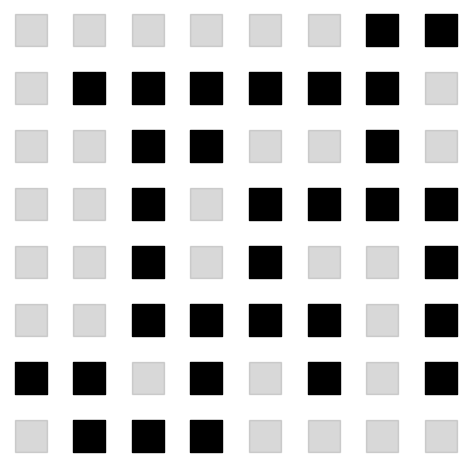

5


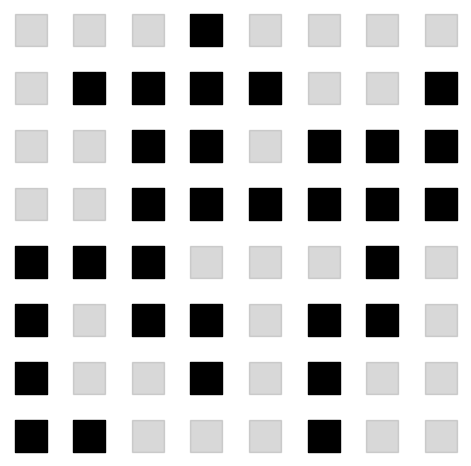

6


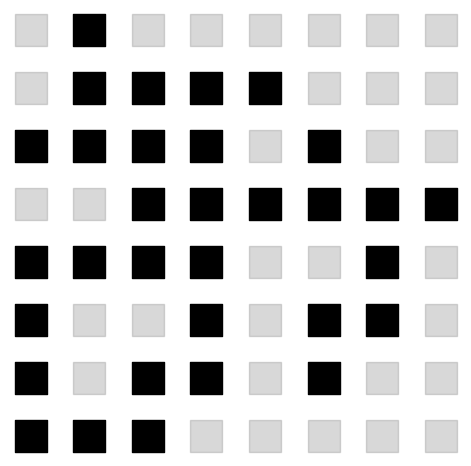

7


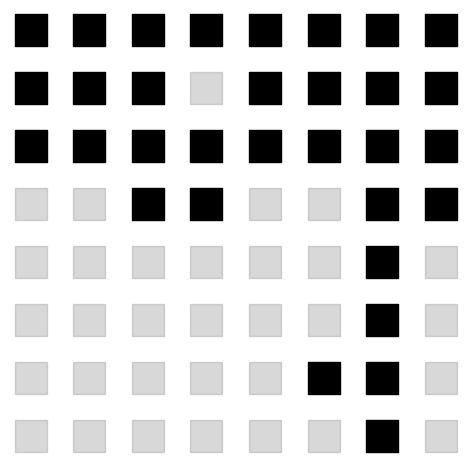

In [36]:
cntu = True
counter =0
while (cntu and counter< 7):

  A= [v.Not() for i,v in U.items() if solver.value(v)==1]
  B= [v for i,v in U.items() if solver.value(v)==0]

  expressions = A+ B
  model.AddAtLeastOne(expressions)
  status = solver.Solve(model,solution_printer)
  #print(status, solver.StatusName(status), solver.ObjectiveValue())
  if status != cp_model.OPTIMAL:
    cntu = False
  else:
    counter+=1
    print(counter)
    #pass
    plt.figure(figsize=(5,5))
    for i , v in U.items():
      #print(i, dic)
      if solver.value(v):
        plt.scatter(info[i][0],info[i][1],s=500, marker = 's', c= 'k')
      else:
        plt.scatter(info[i][0],info[i][1],s=500, marker = 's', c= 'grey', alpha = 0.3)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

    #"""

